## Import libraries and initialize file path

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os
from PIL import Image

from tqdm import tqdm
from collections import Counter

In [2]:
root_path = '../../dataset/mimic-cxr-pad224/2.0.0'

metadata_file = 'mimic-cxr-2.0.0-metadata.csv'
chexpert_file = 'mimic-cxr-2.0.0-chexpert.csv'
negbio_file = 'mimic-cxr-2.0.0-negbio.csv'
split_file = 'mimic-cxr-2.0.0-split.csv'

img_lists = sorted(glob(os.path.join(root_path, metadata_file)))

## Search metadata.csv and preprocess

### MIMIC metdata csv information

In [3]:
metadata = pd.read_csv(os.path.join(root_path, metadata_file))
metadata.head()

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN


In [50]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377110 entries, 0 to 377109
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    377110 non-null  object 
 1   subject_id                                  377110 non-null  int64  
 2   study_id                                    377110 non-null  int64  
 3   PerformedProcedureStepDescription           341598 non-null  object 
 4   ViewPosition                                361341 non-null  object 
 5   Rows                                        377110 non-null  int64  
 6   Columns                                     377110 non-null  int64  
 7   StudyDate                                   377110 non-null  int64  
 8   StudyTime                                   377110 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           377110 non-null  object 
 

### Check study_id frequency

In [85]:
times = Counter(metadata.study_id.value_counts().values)

study_id_times = sorted(times.items(), key=lambda x: x[1], reverse=True)
study_id_times_keys = [items[0] for items in study_id_times]
study_id_times_values = [items[1] for items in study_id_times]

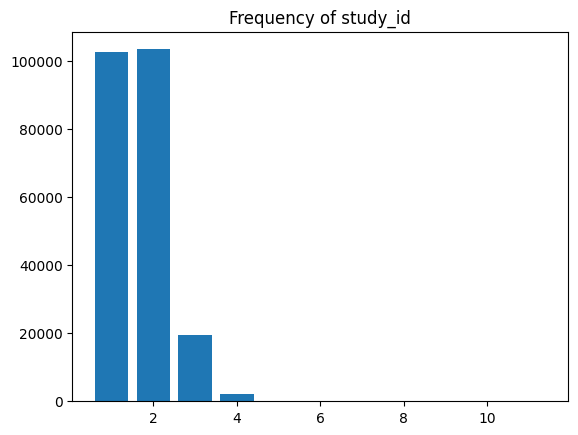

In [97]:
plt.bar(study_id_times_keys, height=study_id_times_values)
plt.title('Frequency of study_id')
plt.show()

### Check view positions

In [5]:
view_position = metadata.ViewPosition.values
cnt_position = Counter(view_position)
cnt_position

Counter({'PA': 96161,
         'LATERAL': 82853,
         'AP': 147173,
         'LL': 35133,
         nan: 15769,
         'LAO': 3,
         'RAO': 3,
         'AP AXIAL': 2,
         'SWIMMERS': 1,
         'PA LLD': 4,
         'AP LLD': 2,
         'XTABLE LATERAL': 2,
         'AP RLD': 2,
         'PA RLD': 1,
         'LPO': 1})

In [6]:
vp_key = []
vp_value = []

for key, value in cnt_position.items():
    vp_key.append(key)
    vp_value.append(value)

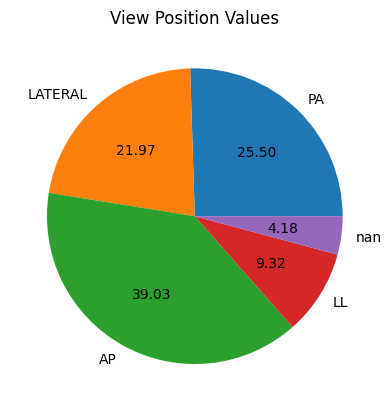

In [7]:
plt.pie(vp_value[:5], labels=vp_key[:5], autopct='%.2f')
plt.title('View Position Values')
plt.show()

In [8]:
metadata.ViewCodeSequence_CodeMeaning.value_counts()
view_sequence = metadata.ViewCodeSequence_CodeMeaning.values
cnt_sequence = Counter(view_sequence)
cnt_sequence

Counter({'postero-anterior': 95858,
         'lateral': 82612,
         'antero-posterior': 146448,
         'left lateral': 35033,
         nan: 16497,
         'Erect': 623,
         'Recumbent': 18,
         'left anterior oblique': 21})

In [9]:
vs_key = []
vs_value = []

for key, value in cnt_sequence.items():
    vs_key.append(key)
    vs_value.append(value)

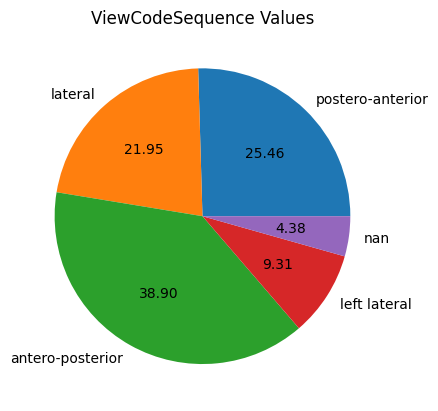

In [10]:
plt.pie(vs_value[:5], labels=vs_key[:5], autopct='%.2f')
plt.title('ViewCodeSequence Values')
plt.show()

In [11]:
# Check the value of ViewCodeSequence_CodeMeaning is NaN if the value of ViewPosition is NaN.
view_position_na = metadata[metadata.ViewPosition.isna()]
view_position_na.ViewCodeSequence_CodeMeaning.value_counts()

Series([], Name: ViewCodeSequence_CodeMeaning, dtype: int64)

### Preprocessing: Drop NaN rows by ViewPosition

In [13]:
metadata_drop_na = metadata.dropna(subset=['ViewPosition'])
metadata_drop_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361341 entries, 0 to 377109
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    361341 non-null  object 
 1   subject_id                                  361341 non-null  int64  
 2   study_id                                    361341 non-null  int64  
 3   PerformedProcedureStepDescription           326971 non-null  object 
 4   ViewPosition                                361341 non-null  object 
 5   Rows                                        361341 non-null  int64  
 6   Columns                                     361341 non-null  int64  
 7   StudyDate                                   361341 non-null  int64  
 8   StudyTime                                   361341 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           361341 non-null  object 
 

### Preprocessing: Drop rows that ViewPosition values aren't 'AP' or 'PA'

In [14]:
metadata_ap_pa = metadata_drop_na[(metadata_drop_na['ViewPosition'] == 'AP') | (metadata_drop_na['ViewPosition'] == 'PA')]
metadata_ap_pa.ViewPosition.value_counts()

AP    147173
PA     96161
Name: ViewPosition, dtype: int64

In [15]:
metadata_ap_pa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243334 entries, 0 to 377109
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    243334 non-null  object 
 1   subject_id                                  243334 non-null  int64  
 2   study_id                                    243334 non-null  int64  
 3   PerformedProcedureStepDescription           225266 non-null  object 
 4   ViewPosition                                243334 non-null  object 
 5   Rows                                        243334 non-null  int64  
 6   Columns                                     243334 non-null  int64  
 7   StudyDate                                   243334 non-null  int64  
 8   StudyTime                                   243334 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           243334 non-null  object 
 

In [16]:
view_select = metadata_ap_pa.groupby(['ViewPosition', 'ViewCodeSequence_CodeMeaning']).dicom_id.count()
view_select

ViewPosition  ViewCodeSequence_CodeMeaning
AP            Erect                              188
              Recumbent                           15
              antero-posterior                146442
              left anterior oblique               18
PA            Erect                              190
              postero-anterior                 95855
Name: dicom_id, dtype: int64

### Preprocessing: Drop the rows that ViewCodeSequence_CodeMeaning values are 'Recumbent' or 'left anterior oblique'

In [20]:
metadata_preprocess = metadata_ap_pa[(metadata_ap_pa['ViewCodeSequence_CodeMeaning'] != 'Recumbent') & (metadata_ap_pa['ViewCodeSequence_CodeMeaning'] != 'left anterior oblique')]
metadata_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243301 entries, 0 to 377109
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    243301 non-null  object 
 1   subject_id                                  243301 non-null  int64  
 2   study_id                                    243301 non-null  int64  
 3   PerformedProcedureStepDescription           225266 non-null  object 
 4   ViewPosition                                243301 non-null  object 
 5   Rows                                        243301 non-null  int64  
 6   Columns                                     243301 non-null  int64  
 7   StudyDate                                   243301 non-null  int64  
 8   StudyTime                                   243301 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           243301 non-null  object 
 

## Combine with labels

### Check negbio labeler csv informations

In [21]:
negbio_csv = pd.read_csv(os.path.join(root_path, negbio_file))
negbio_csv.head(5)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [22]:
negbio_csv

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
227823,19999733,57132437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
227824,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
227825,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [23]:
len(negbio_csv)

227827

### Preprocessing: Drop the rows that not exist both negbio csv and metadata csv

In [24]:
no_label_id = []
not_in_metadata_id = []

# The study_ids not in the metadata csv but in the negbio csv.
for study_id in tqdm(negbio_csv.study_id.values):
    if study_id not in metadata_preprocess.study_id.values:
        not_in_metadata_id.append(study_id)
        
# The study_ids not in the negbio csv but in the metadata csv.
for study_id in tqdm(metadata_preprocess.study_id.values):
    if study_id not in negbio_csv.study_id.values:
        no_label_id.append(study_id)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 243301/243301 [00:31<00:00, 7663.88it/s]


In [25]:
len(set(no_label_id)), len(set(not_in_metadata_id))

(8, 9714)

In [26]:
len(set(metadata_preprocess.study_id.values))

218121

In [27]:
negbio_preprocess = negbio_csv.loc[~negbio_csv['study_id'].isin(not_in_metadata_id)]
negbio_preprocess.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [28]:
metadata_preprocess = metadata_preprocess.loc[~metadata_preprocess['study_id'].isin(no_label_id)]
metadata_preprocess.head()

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,CHEST (PORTABLE AP),AP,2906,2258,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,CHEST (PORTABLE AP),AP,3056,2544,21800805,234424.765,CHEST (PORTABLE AP),antero-posterior,NaN


In [48]:
metadata_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243291 entries, 0 to 377109
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    243291 non-null  object 
 1   subject_id                                  243291 non-null  int64  
 2   study_id                                    243291 non-null  int64  
 3   PerformedProcedureStepDescription           225259 non-null  object 
 4   ViewPosition                                243291 non-null  object 
 5   Rows                                        243291 non-null  int64  
 6   Columns                                     243291 non-null  int64  
 7   StudyDate                                   243291 non-null  int64  
 8   StudyTime                                   243291 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           243291 non-null  object 
 

## Save the preprocessed metadata csv

In [29]:
# metadata_preprocess.to_csv('mimic_csv_preprocess.csv', index=False)

## If you want to split by provided split csv, you can use.

In [30]:
split_csv = pd.read_csv(os.path.join(root_path, split_file))
split_csv_preprocess = split_csv.loc[split_csv['study_id'].isin(metadata_preprocess.study_id.values)]

In [31]:
file_path_csv = pd.read_csv(os.path.join(root_path, '../mimic-cxr-2.0.0-filepath.csv'))
file_path_preprocess = file_path_csv.loc[file_path_csv['dicom_id'].isin(metadata_preprocess.dicom_id.values)]

In [32]:
new_trainer = pd.merge(metadata_preprocess, negbio_preprocess)
new_trainer = pd.merge(new_trainer, file_path_preprocess.loc[:, ['dicom_id', 'Path']])
new_trainer = pd.merge(new_trainer, split_csv.loc[:, ['dicom_id', 'split']])

new_trainer.ViewPosition = 'Frontal'
new_trainer.rename(columns={'ViewPosition': 'Frontal/Lateral'}, inplace=True)

In [33]:
new_trainer.head(5)

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,Frontal/Lateral,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,...,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,Path,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),Frontal,3056,2544,21800506,213014.531,CHEST (PA AND LAT),...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,mimic-cxr-pad224/2.0.0/files/p10/p10000032/s50...,train
1,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),Frontal,3056,2544,21800626,165500.312,CHEST (PA AND LAT),...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,mimic-cxr-pad224/2.0.0/files/p10/p10000032/s53...,train
2,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),Frontal,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,mimic-cxr-pad224/2.0.0/files/p10/p10000032/s53...,train
3,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,CHEST (PORTABLE AP),Frontal,2906,2258,21800723,80556.875,CHEST (PORTABLE AP),...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,mimic-cxr-pad224/2.0.0/files/p10/p10000032/s53...,train
4,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,CHEST (PORTABLE AP),Frontal,3056,2544,21800805,234424.765,CHEST (PORTABLE AP),...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,mimic-cxr-pad224/2.0.0/files/p10/p10000032/s56...,train


## Save train, valid, test csv

In [34]:
save_base_path = '/home/MIMIC_code/kyoungmin/labeler/negbio'

In [41]:
train_new_trainer = new_trainer[new_trainer.split == 'train']
# train_new_trainer.to_csv(os.path.join(save_base_path, 'train.csv'), index=False)

In [42]:
valid_new_trainer = new_trainer[new_trainer.split == 'validate']
# valid_new_trainer.to_csv(os.path.join(save_base_path, 'valid.csv'), index=False)

In [43]:
test_new_trainer = new_trainer[new_trainer.split == 'test']
# test_new_trainer.to_csv(os.path.join(save_base_path, 'test.csv'), index=False)

In [47]:
new_trainer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243291 entries, 0 to 243290
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    243291 non-null  object 
 1   subject_id                                  243291 non-null  int64  
 2   study_id                                    243291 non-null  int64  
 3   PerformedProcedureStepDescription           225259 non-null  object 
 4   Frontal/Lateral                             243291 non-null  object 
 5   Rows                                        243291 non-null  int64  
 6   Columns                                     243291 non-null  int64  
 7   StudyDate                                   243291 non-null  int64  
 8   StudyTime                                   243291 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           243291 non-null  object 
 

## Check the label distributions

In [44]:
train_new_trainer = pd.read_csv(os.path.join(save_base_path, 'train.csv'))
train_new_trainer.drop(columns=['PerformedProcedureStepDescription', 'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning', 'PatientOrientationCodeSequence_CodeMeaning', 'Path', 'split'], inplace=True)
train_new_trainer.head()

,dicom_id,subject_id,study_id,Frontal/Lateral,Rows,Columns,StudyDate,StudyTime,Atelectasis,Cardiomegaly,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,Frontal,3056,2544,21800506,213014.531,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,Frontal,3056,2544,21800626,165500.312,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,Frontal,2705,2539,21800723,80556.875,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,Frontal,2906,2258,21800723,80556.875,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,Frontal,3056,2544,21800805,234424.765,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [45]:
target_cols = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

def calculate_label(df: pd.DataFrame, ratio=False, include_nan=True):
    series_nan = df.isnull().sum()
    series_unknown = df[df==-1].count()
    series_negative = df[df==0].count()
    series_positive = df[df==1].count()
    if include_nan:
        new_df = pd.concat([series_nan, series_unknown, series_negative, series_positive], axis=1)
        new_df.columns=['Nan', '-1', '0', '1']
    else:
        new_df = pd.concat([series_unknown, series_negative, series_positive], axis=1)
        new_df.columns=['-1', '0', '1']

    if ratio:
        new_df /= len(df)

    # drop if no value in column
    new_df.drop(columns=new_df.columns[new_df.sum()==0], inplace=True)

    return new_df

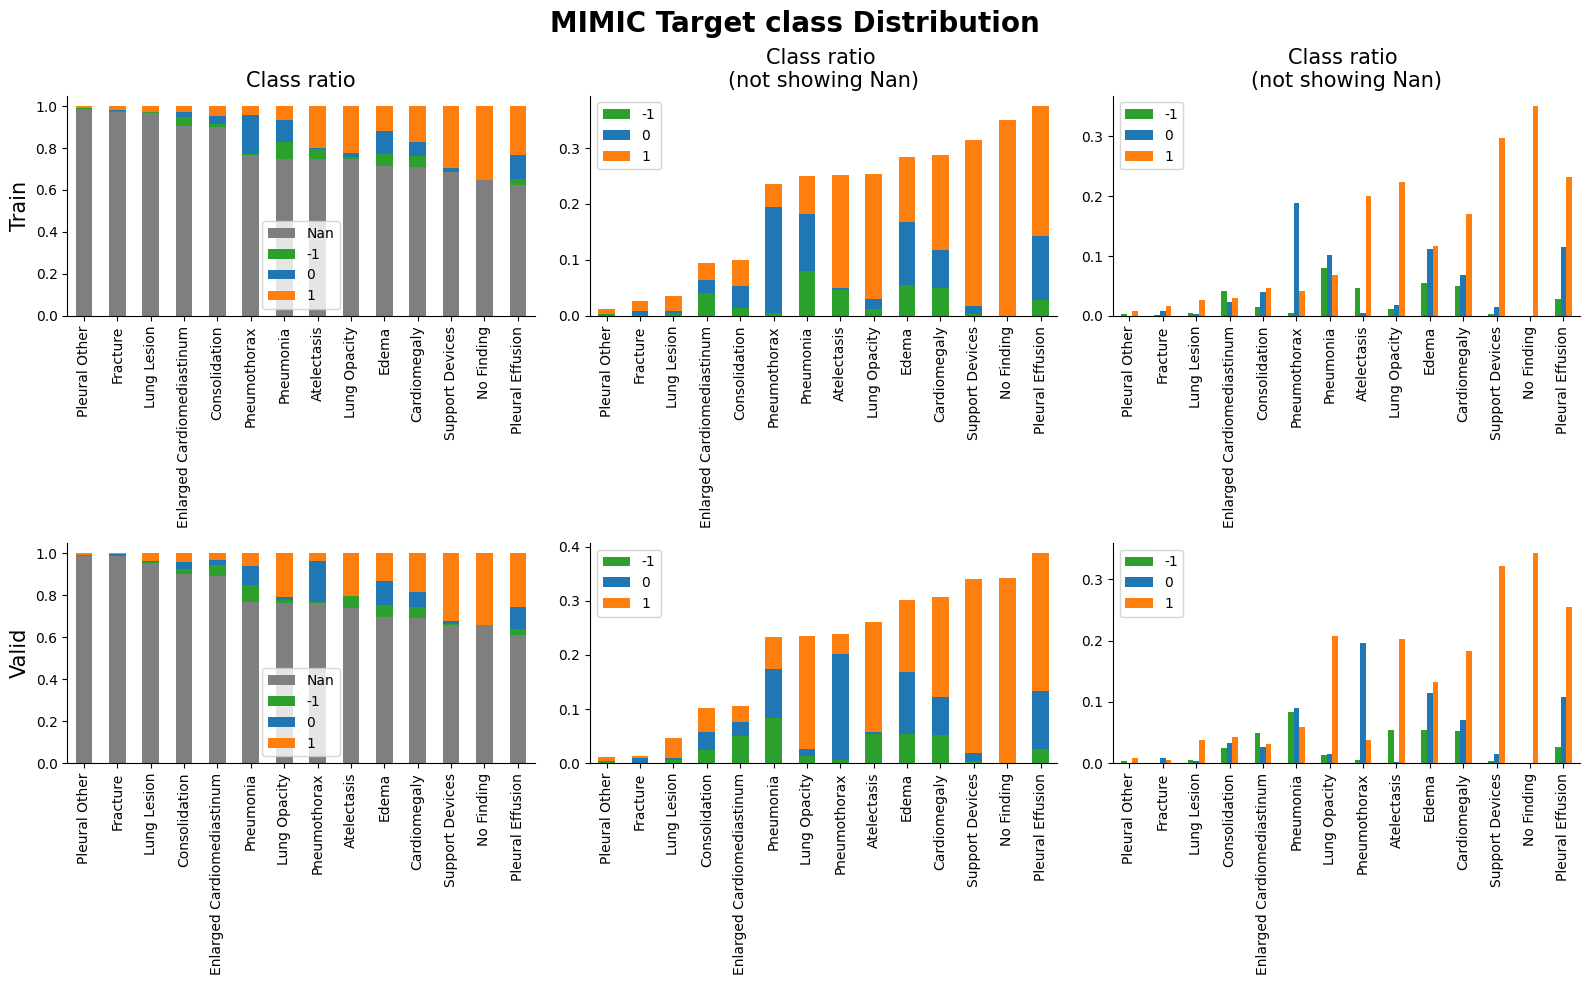

In [46]:
fig_viz, ax_viz = plt.subplots(2, 3, figsize=(16, 10))

calculate_label(train_new_trainer[target_cols], ratio=True, include_nan=True).sort_values('Nan', ascending=False).plot(
    kind='bar', stacked=True, ax=ax_viz[0][0], color=['tab:gray','tab:green','tab:blue','tab:orange'])
order_by_nan_ratio = calculate_label(train_new_trainer[target_cols], ratio=True, include_nan=True).sort_values('Nan', ascending=False).index
calculate_label(train_new_trainer[target_cols], ratio=True, include_nan=False).loc[order_by_nan_ratio, :].plot(
    kind='bar', stacked=True, ax=ax_viz[0][1], color=['tab:green','tab:blue','tab:orange'])
calculate_label(train_new_trainer[target_cols], ratio=True, include_nan=False).loc[order_by_nan_ratio, :].plot(
    kind='bar', stacked=False, ax=ax_viz[0][2], color=['tab:green','tab:blue','tab:orange'])

calculate_label(valid_new_trainer[target_cols], ratio=True, include_nan=True).sort_values('Nan', ascending=False).plot(
    kind='bar', stacked=True, ax=ax_viz[1][0], color=['tab:gray','tab:green','tab:blue','tab:orange'])
order_by_nan_ratio = calculate_label(valid_new_trainer[target_cols], ratio=True, include_nan=True).sort_values('Nan', ascending=False).index
calculate_label(valid_new_trainer[target_cols], ratio=True, include_nan=False).loc[order_by_nan_ratio, :].plot(
    kind='bar', stacked=True, ax=ax_viz[1][1], color=['tab:green','tab:blue','tab:orange'])
calculate_label(valid_new_trainer[target_cols], ratio=True, include_nan=False).loc[order_by_nan_ratio, :].plot(
    kind='bar', stacked=False, ax=ax_viz[1][2], color=['tab:green','tab:blue','tab:orange'])

ax_viz[0][0].set_ylabel('Train', fontsize=15)
ax_viz[1][0].set_ylabel('Valid', fontsize=15)

ax_viz[0][0].set_title('Class ratio', fontsize=15)
ax_viz[0][1].set_title('Class ratio \n(not showing Nan)', fontsize=15)
ax_viz[0][2].set_title('Class ratio \n(not showing Nan)', fontsize=15)

for i in ax_viz:
    for ax in i:
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

fig_viz.suptitle('MIMIC Target class Distribution', fontsize=20, fontweight='bold')
fig_viz.tight_layout()
